In [1]:
#Importing libraries and dataset

import pandas as pd
import numpy as np
import statistics as stats
from sklearn import metrics
from google.colab import files
uploaded = files.upload()
import io
my_data = pd.read_csv(io.BytesIO(uploaded['RL_Dataset.csv']))

my_data.head(3)

Saving RL_Dataset.csv to RL_Dataset (4).csv


,LoanID,WhetherDefaultedFirst18Months,DefaultedBalance,ApplicationTime,HomeOwnership,LoanPurpose,ClientState,NewTradesOpenedLast24Months,NewTradesOpenedLast6Months,ADA3024,ADA3100,ADA3111,ADA3160,ADA3164,ADA3165,UnsecuredNewTradesOpenedLast3Months,UnsecuredNewTradesOpenedLast6Months,UnsecuredNewTradesOpenedLast12Months,RevolvingBalance,RevolvingCreditLimit,RevolvingNewTradesOpenedLast6Months,FICO,YeasSinceOldestAccountOpened,UnsecuredDebtBalance,NumberNonMortgageNonAutoInquiriesLast6Months,MortgageClientFlag,VerifiedAnnualIncome,StatedEmploymentStatus,LoanAmount,LoanTerm,InterestRate,MonthlyPayment,PreCloseDTI,PreCloseAllInDTI
0,1,0,0.0,2016-04-06T15:20:07.976Z,mortgage,debtConsolidation,IL,4,1,2,35,266,9999998,71594,38953,0,0,0,10421,72550,0,787,22.191781,0,2,True,40000.0,Retired,10000,60,11.034,217.59,0.157500,0.276300
1,2,0,0.0,2016-04-07T20:04:16.840Z,rent,business,MA,3,0,0,23,137,9999998,9999997,9999997,0,0,0,2174,7350,0,714,11.452055,0,0,False,37000.0,Employed,6001,36,16.288,211.83,0.303286,0.303286
2,3,0,0.0,2016-04-14T18:18:47.064Z,rent,other,WA,1,1,1,17,517,13750,13750,9999998,0,0,0,3573,54800,0,823,43.117808,0,1,False,49500.0,Retired,2500,36,10.085,80.77,0.061576,0.061576


General EDA, cleaning, and pre-processing

In [2]:
#Checking proportion of defaults. Too many or too few would require a zero-inflated model
sum(my_data['WhetherDefaultedFirst18Months']==0) / my_data.shape[0]
#Result is ~93.5%. Data is certainly unbalanced at first glance

0.9363030649152865

In [3]:
#Changing all state abbreviations to uppercase
my_data['ClientState'] = my_data['ClientState'].str.upper()

#len(my_data['ClientState'].unique()) # = 51 (includes DC)

In [4]:
#Pre-processing: assigning numerics to some of the categorical variables

#list(my_data['HomeOwnership'].unique())
my_data['HomeOwnership'] = my_data['HomeOwnership'].map({'mortgage':0, 'own':1, 'rent':2}) #ordered alphabetically

#list(my_data['LoanPurpose'].unique())
my_data['LoanPurpose'] = my_data['LoanPurpose'].map({'auto':0, 'business':1, 'debtConsolidation':2, 'debtConsolidation_creditCard':3, 'debtConsolidation_mortgage':4, 'debtConsolidation_otherLoan':5, 'homeImprovement':6, 'homeImprovement_repairs':7, 'medicalExpenses':8, 'other':9}) #ordered alphabetically

#list(my_data['StatedEmploymentStatus'].unique())
my_data['StatedEmploymentStatus'] = my_data['StatedEmploymentStatus'].map({'Employed':0, 'Other':1, 'Retired':2, 'Self-Employed':3}) #ordered alphabetically

#list(my_data['MortgageClientFlag'].unique())
for i in range(0, my_data.shape[0]):
  my_data['MortgageClientFlag'].iloc[i] = int(my_data['MortgageClientFlag'].iloc[i])
temp_list=list(my_data['MortgageClientFlag'])
my_data['MortgageClientFlag'] = temp_list

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [5]:
#EDA: Colinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = my_data[['DefaultedBalance', 'HomeOwnership', 'LoanPurpose', 'NewTradesOpenedLast24Months', 'NewTradesOpenedLast6Months', 'ADA3024', 'ADA3100', 'ADA3111', 'ADA3160', 'ADA3164', 'ADA3165', 'UnsecuredNewTradesOpenedLast3Months', 'UnsecuredNewTradesOpenedLast6Months', 'UnsecuredNewTradesOpenedLast12Months', 'RevolvingBalance', 'RevolvingCreditLimit', 'RevolvingNewTradesOpenedLast6Months', 'FICO', 'YeasSinceOldestAccountOpened', 'UnsecuredDebtBalance', 'NumberNonMortgageNonAutoInquiriesLast6Months', 'MortgageClientFlag', 'VerifiedAnnualIncome', 'StatedEmploymentStatus', 'LoanAmount', 'LoanTerm', 'InterestRate', 'MonthlyPayment', 'PreCloseDTI', 'PreCloseAllInDTI']]
X = X.dropna()

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
print(vif_data)

#Result: some variables have VIF > 100, which is extremely high

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                                         feature          VIF
0                               DefaultedBalance     1.097024
1                                  HomeOwnership     2.218880
2                                    LoanPurpose     3.249340
3                    NewTradesOpenedLast24Months     5.828389
4                     NewTradesOpenedLast6Months     6.374581
5                                        ADA3024     1.163287
6                                        ADA3100     8.862439
7                                        ADA3111  1339.056729
8                                        ADA3160     2.141299
9                                        ADA3164     1.367701
10                                       ADA3165     4.193405
11           UnsecuredNewTradesOpenedLast3Months     1.888939
12           UnsecuredNewTradesOpenedLast6Months     3.632123
13          UnsecuredNewTradesOpenedLast12Months     2.848107
14                              RevolvingBalance     4.498722
15      

In [6]:
#Further examination

X.corr()
#cor(YeasSinceOldestAccountOpened, ADA3111) is ~1.
#Intuitively, they measure the same thing. Since "YeasSinceOldestAccountOpened" is likely more digestable to others in the pipeline, it will be kept, and ADA3111 will be removed)

my_data = my_data.drop('ADA3111', axis = 1)

In [7]:
#Re-running without ADA3111

X = my_data[['DefaultedBalance', 'HomeOwnership', 'LoanPurpose', 'NewTradesOpenedLast24Months', 'NewTradesOpenedLast6Months', 'ADA3024', 'ADA3100', 'ADA3160', 'ADA3164', 'ADA3165', 'UnsecuredNewTradesOpenedLast3Months', 'UnsecuredNewTradesOpenedLast6Months', 'UnsecuredNewTradesOpenedLast12Months', 'RevolvingBalance', 'RevolvingCreditLimit', 'RevolvingNewTradesOpenedLast6Months', 'FICO', 'YeasSinceOldestAccountOpened', 'UnsecuredDebtBalance', 'NumberNonMortgageNonAutoInquiriesLast6Months', 'MortgageClientFlag', 'VerifiedAnnualIncome', 'StatedEmploymentStatus', 'LoanAmount', 'LoanTerm', 'InterestRate', 'MonthlyPayment', 'PreCloseDTI', 'PreCloseAllInDTI']]
X = X.dropna()

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
print(vif_data)

                                         feature        VIF
0                               DefaultedBalance   1.096635
1                                  HomeOwnership   2.218860
2                                    LoanPurpose   3.249282
3                    NewTradesOpenedLast24Months   5.827511
4                     NewTradesOpenedLast6Months   6.373562
5                                        ADA3024   1.163279
6                                        ADA3100   8.849006
7                                        ADA3160   2.141289
8                                        ADA3164   1.367700
9                                        ADA3165   4.193382
10           UnsecuredNewTradesOpenedLast3Months   1.888922
11           UnsecuredNewTradesOpenedLast6Months   3.631995
12          UnsecuredNewTradesOpenedLast12Months   2.848069
13                              RevolvingBalance   4.496411
14                          RevolvingCreditLimit   5.061776
15           RevolvingNewTradesOpenedLas

In [8]:
X.corr()
#Loanamount somewhat or strongly correlated with FICO, revolving credit limit, verified annual income, monthly payment. These make intuitive sense
#No more removal needed; all remaining correlations are logical and not multicollinear

,DefaultedBalance,HomeOwnership,LoanPurpose,NewTradesOpenedLast24Months,NewTradesOpenedLast6Months,ADA3024,ADA3100,ADA3160,ADA3164,ADA3165,UnsecuredNewTradesOpenedLast3Months,UnsecuredNewTradesOpenedLast6Months,UnsecuredNewTradesOpenedLast12Months,RevolvingBalance,RevolvingCreditLimit,RevolvingNewTradesOpenedLast6Months,FICO,YeasSinceOldestAccountOpened,UnsecuredDebtBalance,NumberNonMortgageNonAutoInquiriesLast6Months,MortgageClientFlag,VerifiedAnnualIncome,StatedEmploymentStatus,LoanAmount,LoanTerm,InterestRate,MonthlyPayment,PreCloseDTI,PreCloseAllInDTI
DefaultedBalance,1.000000,0.056717,0.018858,0.042394,0.038539,-0.022666,-0.021411,0.017456,0.048789,0.083218,0.022408,0.024122,0.026447,-0.037643,-0.036459,0.033849,-0.019333,-0.033177,-0.005110,0.099363,-0.103264,-0.029790,0.022904,0.096749,0.032514,0.041995,0.100521,-0.001012,-0.042350
HomeOwnership,0.056717,1.000000,0.046045,-0.034075,0.020102,0.042238,-0.164108,0.019313,0.166419,0.552998,0.031348,0.035247,0.027138,-0.110957,-0.095368,0.049437,0.005642,-0.173468,-0.020180,0.025201,-0.358161,-0.078151,-0.035811,-0.097381,-0.051736,0.061356,-0.078533,-0.011530,-0.325987
LoanPurpose,0.018858,0.046045,1.000000,-0.089727,-0.024719,0.014177,-0.118078,0.028764,0.043761,0.070418,-0.005200,-0.017181,-0.036510,-0.175772,-0.091466,-0.029186,0.130842,-0.020810,-0.051196,0.039804,-0.114235,-0.005720,0.035928,-0.036012,0.011670,0.000403,-0.044789,-0.131826,-0.108412
NewTradesOpenedLast24Months,0.042394,-0.034075,-0.089727,1.000000,0.530878,-0.191497,0.437426,-0.177663,-0.080513,-0.048542,0.150419,0.226170,0.337943,0.026368,0.158738,0.408705,-0.128963,-0.064194,0.140737,0.266254,0.048058,0.033383,-0.041269,-0.087574,-0.008591,0.115434,-0.074011,0.261300,0.162771
NewTradesOpenedLast6Months,0.038539,0.020102,-0.024719,0.530878,1.000000,-0.099904,0.215870,-0.096856,-0.036465,0.010477,0.243418,0.363307,0.294170,-0.056225,0.051560,0.737384,-0.071431,-0.058864,0.117139,0.355816,-0.026328,0.007749,-0.026047,-0.079339,-0.002761,0.058915,-0.073977,0.127573,0.060900
ADA3024,-0.022666,0.042238,0.014177,-0.191497,-0.099904,1.000000,-0.082973,0.072499,0.037031,0.036266,-0.015559,-0.025887,-0.041615,0.009385,-0.008618,-0.068886,0.079195,0.024803,-0.011660,-0.156131,-0.051023,-0.012773,-0.003192,0.011633,-0.014335,-0.069696,0.010196,-0.052866,-0.065671
ADA3100,-0.021411,-0.164108,-0.118078,0.437426,0.215870,-0.082973,1.000000,-0.146028,-0.111932,-0.224550,0.056141,0.093110,0.160691,0.294140,0.475593,0.153313,0.080801,0.320312,0.161731,0.084905,0.170575,0.197148,0.006075,0.110808,0.008381,-0.076525,0.105679,0.320660,0.273709
ADA3160,0.017456,0.019313,0.028764,-0.177663,-0.096856,0.072499,-0.146028,1.000000,0.284848,0.022484,-0.001230,-0.009602,-0.013559,-0.056020,-0.030123,-0.005511,0.012182,0.035619,-0.031455,-0.073068,-0.015473,-0.129582,0.087192,-0.014553,-0.005873,-0.059783,-0.019471,-0.424523,-0.175060
ADA3164,0.048789,0.166419,0.043761,-0.080513,-0.036465,0.037031,-0.111932,0.284848,1.000000,0.333555,-0.028394,-0.039529,-0.053622,-0.051914,-0.034211,0.033831,0.008919,-0.038365,-0.059593,0.014480,-0.189995,-0.038106,0.019237,-0.001692,-0.007819,-0.000184,0.001606,-0.207423,-0.296454
ADA3165,0.083218,0.552998,0.070418,-0.048542,0.010477,0.036266,-0.224550,0.022484,0.333555,1.000000,0.033090,0.043265,0.034604,-0.198006,-0.172363,0.052626,-0.030655,-0.223166,-0.039792,0.105679,-0.565295,-0.120286,-0.037911,-0.123317,-0.062342,0.100790,-0.100715,-0.035527,-0.589797


In [9]:
#Mapping some of the ADA columns to null values
#Missing values will not be skipped over by Isolation Forest

for i in range(0, my_data.shape[0]):
  if ((my_data['ADA3024'].iloc[i]) > 92):
    my_data['ADA3024'].iloc[i] = np.NaN

for i in range(0, my_data.shape[0]):
  if ((my_data['ADA3100'].iloc[i]) > 92):
    my_data['ADA3100'].iloc[i] = np.NaN

#for i in range(0, my_data.shape[0]):
#  if ((my_data['ADA3111'].iloc[i]) > 9992):
#    my_data['ADA3111'].iloc[i] = np.NaN

for i in range(0, my_data.shape[0]):
  if ((my_data['ADA3160'].iloc[i]) > 9999992):
    my_data['ADA3160'].iloc[i] = np.NaN

for i in range(0, my_data.shape[0]):
  if ((my_data['ADA3164'].iloc[i]) > 9999992):
    my_data['ADA3164'].iloc[i] = np.NaN

for i in range(0, my_data.shape[0]):
  if ((my_data['ADA3165'].iloc[i]) > 9999992):
    my_data['ADA3165'].iloc[i] = np.NaN

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [10]:
#Hour the application was filed at

Hour_of_App=[None] * my_data.shape[0] #significantly faster than creating an empty list and appending it

for i in range(0, my_data.shape[0]):
  Hour_of_App[i] = int((my_data['ApplicationTime'].iloc[i]).rsplit("T")[1][0:2])

my_data["Hour_of_App"] = Hour_of_App

In [11]:
#Metric functions. Not using pre-packaged functions due to labeling methodology in sklearn

#Accuracy
def accuracy(tp, fp, fn, tn):
  return ((tp+tn)/(tp+fp+fn+tn))

#True positive rate; same as recall
def recall(tp, fn):
  return(tp/(tp+fn))

#True negative rate; often called "specificity" or "selectivity"
def true_neg_rate(tn, fp):
  return(tn/(tn+fp))

# Isolation Forest: Iterative Models

In [12]:
#Isolation Forest

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn import metrics
iso_auc=[]
iso_recall=[]
iso_tnr=[]
iso_balanced_acc=[]
contam=[]

#Subsetting data appropriately
data = my_data.drop(['LoanID', 'WhetherDefaultedFirst18Months', 'ApplicationTime', 'DefaultedBalance'], axis=1)

  #Label Encoding
for col in data.columns:
  if data[col].dtype == "object":
    le = LabelEncoder()
    data[col].fillna("None", inplace=True)
    le.fit(list(data[col].astype(str).values))
    data[col] = le.transform(list(data[col].astype(str).values))
  else:
    data[col].fillna(-999, inplace=True)

#Running isolation forest 100 times, collecting each AUC and recall score
for i in range(0, 100):
  #contamination values from 0.005 to 0.5, in increments of 0.005
  contamination = (.005*(i+1))

  #IsoForest Model
  model = IsolationForest(contamination=contamination)
  model.fit(data)

  #Applying scores to dataframe
  my_data_iso = my_data
  my_data_iso["iforest_score"] = pd.Series(model.predict(data))
  my_data_iso["iforest_score"] = my_data_iso["iforest_score"].map({1:0, -1:1})
  my_data_iso["pos_neg_score"] = pd.Series(model.decision_function(data))

  #AUC score for model i
  my_data_iso = my_data_iso.sort_values(by=['pos_neg_score'])
  iso_auc.append(1 - metrics.auc(my_data_iso["pos_neg_score"], my_data_iso["iforest_score"]))

  #Metrics for model i
  iso_matrix = metrics.confusion_matrix(my_data_iso['WhetherDefaultedFirst18Months'], my_data_iso['iforest_score'])
  iso_recall.append(recall(iso_matrix[1,1], iso_matrix[1,0]))
  iso_tnr.append(true_neg_rate(iso_matrix[0,0], iso_matrix[0,1]))
  iso_balanced_acc.append((iso_recall[i]+iso_tnr[i])/2)
  contam.append(contamination)

0.7955520688526782
0.5867506055064924


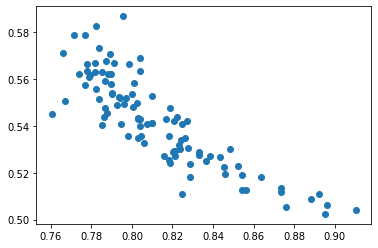

In [13]:
import matplotlib.pyplot as plt
plt.scatter(iso_auc, iso_balanced_acc)

print(iso_auc[np.argmax(iso_balanced_acc)])
print(iso_balanced_acc[np.argmax(iso_balanced_acc)])

In [14]:
#Selecting the best-ranked combination of AUC and balanced accuracy

rankorder_minus_one = sorted(range(len(iso_auc)), key=iso_auc.__getitem__)
auc_rankorder = [1+x for x in rankorder_minus_one]

rankorder_minus_one = sorted(range(len(iso_balanced_acc)), key=iso_balanced_acc.__getitem__)
acc_rankorder = [1+x for x in rankorder_minus_one]

sum_of_ranks=[]
for i in range(0, len(acc_rankorder)):
  sum_of_ranks.append(auc_rankorder[i] + acc_rankorder[i])

print(np.argmin(sum_of_ranks))
print(min(sum_of_ranks))

67
63


In [15]:
contamination = contam[np.argmin(sum_of_ranks)]
contamination

0.34

# Isolation Forest: Final Model

In [20]:
#Final Isolation Forest model, with contamination resulting in maximized AUC

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
contamination = contamination

#Subsetting data appropriately
data = my_data.drop(['LoanID', 'WhetherDefaultedFirst18Months', 'ApplicationTime', 'DefaultedBalance'], axis=1)

#Label Encoding
for col in data.columns:
	if data[col].dtype == "object":
		le = LabelEncoder()
		data[col].fillna("None", inplace=True)
		le.fit(list(data[col].astype(str).values))
		data[col] = le.transform(list(data[col].astype(str).values))
	else:
		data[col].fillna(-999, inplace=True)

#IsoForest Model
model = IsolationForest(contamination=contamination)
model.fit(data)

#Applying scores to dataframe
my_data_iso = my_data
my_data_iso["iforest_score"] = pd.Series(model.predict(data))
my_data_iso["iforest_score"] = my_data_iso["iforest_score"].map({1:0, -1:1})
my_data_iso["pos_neg_score"] = pd.Series(model.decision_function(data))

#Back-transforming scores to probabilities
probability = list(my_data_iso['pos_neg_score'])
min_prob = min(probability)
for i in range(0, len(probability)):
  probability[i] = probability[i] - min_prob
max_prob = max(probability)
for i in range(0, len(probability)):
  probability[i] = probability[i] / max_prob
for i in range(0, len(probability)):
  probability[i] = 1-probability[i]
my_data_iso["probability"] = probability

In [22]:
my_data_iso.to_csv("Kalra_Output.csv")

In [21]:
my_data_iso.head(2)

,LoanID,WhetherDefaultedFirst18Months,DefaultedBalance,ApplicationTime,HomeOwnership,LoanPurpose,ClientState,NewTradesOpenedLast24Months,NewTradesOpenedLast6Months,ADA3024,ADA3100,ADA3160,ADA3164,ADA3165,UnsecuredNewTradesOpenedLast3Months,UnsecuredNewTradesOpenedLast6Months,UnsecuredNewTradesOpenedLast12Months,RevolvingBalance,RevolvingCreditLimit,RevolvingNewTradesOpenedLast6Months,FICO,YeasSinceOldestAccountOpened,UnsecuredDebtBalance,NumberNonMortgageNonAutoInquiriesLast6Months,MortgageClientFlag,VerifiedAnnualIncome,StatedEmploymentStatus,LoanAmount,LoanTerm,InterestRate,MonthlyPayment,PreCloseDTI,PreCloseAllInDTI,Hour_of_App,iforest_score,pos_neg_score,probability
0,1,0,0.0,2016-04-06T15:20:07.976Z,0,2,IL,4,1,2.0,35,NaN,71594.0,38953.0,0,0,0,10421,72550,0,787,22.191781,0,2,1,40000.0,2,10000,60,11.034,217.59,0.157500,0.276300,15,0,0.037282,0.172276
1,2,0,0.0,2016-04-07T20:04:16.840Z,2,1,MA,3,0,0.0,23,NaN,NaN,NaN,0,0,0,2174,7350,0,714,11.452055,0,0,0,37000.0,0,6001,36,16.288,211.83,0.303286,0.303286,20,0,0.028353,0.205413


In [36]:
#Balanced accuracy
iso_matrix = metrics.confusion_matrix(my_data_iso['WhetherDefaultedFirst18Months'], my_data_iso['iforest_score'])
#(iso_matrix)
#print((iso_matrix[0,0] + iso_matrix[1,1]) / (iso_matrix[0,0] + iso_matrix[1,1] + iso_matrix[1,0] + iso_matrix[0,1]))
iso_matrix = metrics.confusion_matrix(my_data_iso['WhetherDefaultedFirst18Months'], my_data_iso['iforest_score'])
iso_recall = (recall(iso_matrix[1,1], iso_matrix[1,0]))
iso_tnr = (true_neg_rate(iso_matrix[0,0], iso_matrix[0,1]))
iso_balanced_acc = ((iso_recall+iso_tnr)/2)
print(iso_balanced_acc)

#AUC
my_data_iso = my_data_iso.sort_values(by=['pos_neg_score'])
print(1 - metrics.auc(my_data_iso["pos_neg_score"], my_data_iso["iforest_score"]))

0.558472380426079
0.8142574569796734


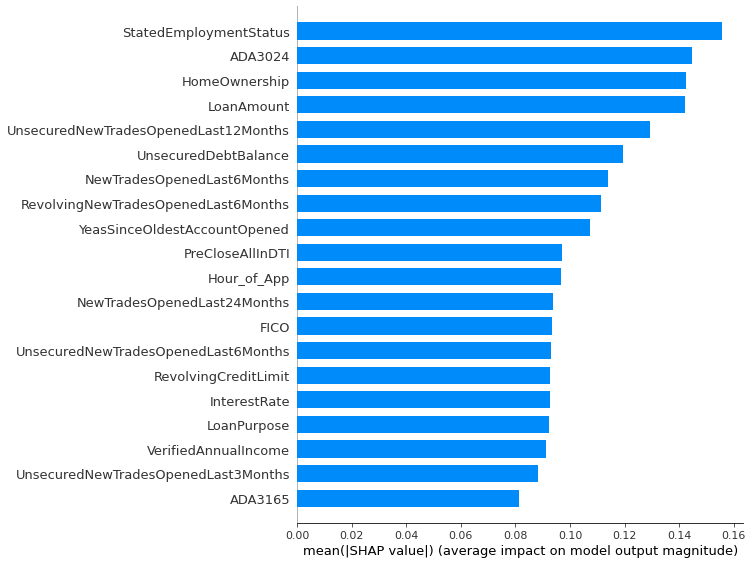

In [25]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(data)
shap.summary_plot(shap_values, data, plot_type="bar")

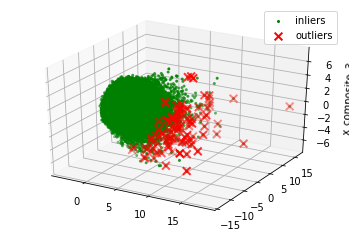

In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
outliers=my_data_iso.loc[my_data_iso['probability']>0.8]
outlier_index=list(outliers.index)

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(data)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2], lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

Appendix (unused content). Would not be turned in or presented; only keeping it should it be referenced further along in the interview process

In [52]:
#Isolation Forest

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
contamination = 0.06 #For unbalanced data with significantly more 0's, a slightly more conservative contamination value is often preferred 

#Subsetting data appropriately
data = my_data.drop(['LoanID', 'WhetherDefaultedFirst18Months', 'ApplicationTime', 'DefaultedBalance'], axis=1)

#Label Encoding
for col in data.columns:
	if data[col].dtype == "object":
		le = LabelEncoder()
		data[col].fillna("None", inplace=True)
		le.fit(list(data[col].astype(str).values))
		data[col] = le.transform(list(data[col].astype(str).values))
	else:
		data[col].fillna(-999, inplace=True)

#IsoForest Model
model = IsolationForest(contamination=contamination)
model.fit(data)

#Applying scores to dataframe
my_data_iso = my_data
my_data_iso["iforest_score"] = pd.Series(model.predict(data))
my_data_iso["iforest_score"] = my_data_iso["iforest_score"].map({1:0, -1:1})
my_data_iso["pos_neg_score"] = pd.Series(model.decision_function(data))

#Result: ~89% accuracy with contam = 0.06

Naïve Bayes Model

In [37]:
#Begin with train-test split
NB_data = my_data.drop(['LoanID', 'ApplicationTime', 'DefaultedBalance'], axis=1)

#NB does not handle missing data well
NB_data = NB_data.dropna()
y = NB_data['WhetherDefaultedFirst18Months']
X = NB_data.drop('WhetherDefaultedFirst18Months', axis = 1)
#Adding in state variable via dummies, since NB cannot consume text
state_dummies = pd.get_dummies(X['ClientState'])
X = pd.concat([X, state_dummies], axis=1)
X = X.drop(['ClientState', "iforest_score", "pos_neg_score"], axis=1)

#running 100 iterations for a more accurate model score
NB_score=[]
for i in range(0, 100):
  #Train-test split. Opting to be slightly more conservative with test split due to low proportion of defaulters
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

  from sklearn.naive_bayes import GaussianNB
  model = GaussianNB()
  model.fit(X_train, y_train)
  NB_score.append(model.score(X_test, y_test))
  
  

print(stats.mean(NB_score))
print(stats.stdev(NB_score))


#~93% accuracy

0.9322660818713451
0.00991852815466365


In [58]:
probs = model.predict_proba(X_test)
probs = [probs[1] for probs in probs]

my_data_NB = X_test.reset_index(drop=True)
NB_predictions = pd.Series(model.predict(X_test), name="pred_y").reset_index(drop=True)
true_y = pd.Series(y_test, name="true_y").reset_index(drop=True)
NB_probs = pd.Series(probs, name="prob_y").reset_index(drop=True)
my_data_NB = pd.concat([my_data_NB, NB_predictions, true_y, NB_probs], axis=1, ignore_index=False)

In [59]:
my_data_NB.head(2)

,HomeOwnership,LoanPurpose,NewTradesOpenedLast24Months,NewTradesOpenedLast6Months,ADA3024,ADA3100,ADA3111,ADA3160,ADA3164,ADA3165,UnsecuredNewTradesOpenedLast3Months,UnsecuredNewTradesOpenedLast6Months,UnsecuredNewTradesOpenedLast12Months,RevolvingBalance,RevolvingCreditLimit,RevolvingNewTradesOpenedLast6Months,FICO,YeasSinceOldestAccountOpened,UnsecuredDebtBalance,NumberNonMortgageNonAutoInquiriesLast6Months,MortgageClientFlag,VerifiedAnnualIncome,StatedEmploymentStatus,LoanAmount,LoanTerm,InterestRate,MonthlyPayment,PreCloseDTI,PreCloseAllInDTI,Hour_of_App,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY,pred_y,true_y,prob_y
0,0,6,6,4,2.0,16,255,30590.0,98507.0,65518.0,0,0,0,13169,25700,1,680,21.271233,0,2,1,75000.0,0,10000,36,18.970,366.41,0.17245,0.258850,14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.101262e-01
1,0,2,4,0,0.0,43,458,38154.0,402527.0,364373.0,0,0,0,53963,161800,0,725,38.271233,0,0,0,101000.0,0,25000,36,14.084,855.46,0.25834,0.449544,8,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.753356e-08


In [67]:
my_data_NB = my_data_NB.sort_values(by=['prob_y'])
1 - metrics.auc(my_data_NB["prob_y"], my_data_NB["pred_y"])

#AUC is ~55%

0.5645909429116797

Model comparison metrics

In [46]:
from sklearn import metrics
NB_matrix = metrics.confusion_matrix(my_data_NB['true_y'], my_data_NB['pred_y'])
iso_matrix = metrics.confusion_matrix(my_data_iso['WhetherDefaultedFirst18Months'], my_data_iso['iforest_score'])

print(NB_matrix)
print(iso_matrix)

[[2535   55]
 [ 142    4]]
[[18343  6249]
 [ 1093   580]]


In [35]:
  iso_recall = (recall(iso_matrix[1,1], iso_matrix[1,0]))
  iso_tnr = true_neg_rate(iso_matrix[0,0], iso_matrix[0,1])
  iso_balanced_acc = ((iso_recall+iso_tnr)/2)